# W205 Project 3
## AGM Business Improvement

### Team Members
#### Siddhartha Gupte
#### Kumar Kallurupalli
#### Tigran Poladian

Data science demonstration for the AGM data science team using the BART transportation system.

### BART TRACK LAYOUT

![Bart Map](../data/bart_map.png)

In [ ]:
pip install geopy

In [2]:
import neo4j
import csv
import math
import numpy as np
import pandas as pd

import psycopg2

import pymongo

import json

import geopy
from geopy.geocoders import Nominatim

from matplotlib import pyplot as plt

### Support Functions
Reused from W205 Code / Labs

In [3]:
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

cursor = connection.cursor()

In [4]:
#
# function to run a select query and return rows in a pandas dataframe
# pandas puts all numeric values from postgres to float
# if it will fit in an integer, change it to integer
#

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

In [5]:
def my_read_csv_file(file_name, limit):
    "read the csv file and print only the first limit rows"
    
    csv_file = open(file_name, "r")
    
    csv_data = csv.reader(csv_file)
    
    i = 0
    
    for row in csv_data:
        i += 1
        if i <= limit:
            print(row)
            
    print("\nPrinted ", min(limit, i), "lines of ", i, "total lines.")

### Drop tables, create and load from CSV files

In [6]:
connection.rollback()

query = """

drop table if exists stations;
"""

cursor = connection.cursor()
cursor.execute(query)

connection.commit()

In [7]:
connection.rollback()

query = """

drop table if exists lines;

"""

cursor = connection.cursor()
cursor.execute(query)

connection.commit()

In [8]:
connection.rollback()

query = """

drop table if exists travel_times;

"""

cursor = connection.cursor()
cursor.execute(query)

connection.commit()

In [9]:
connection.rollback()

query = """

create table stations (
    station varchar(32),
    latitude numeric(9,6),
    longitude numeric(9,6),
    transfer_time numeric(3),
    primary key (station)
);

"""

cursor = connection.cursor()
cursor.execute(query)

connection.commit()

In [10]:
connection.rollback()

query = """

create table lines (
    line varchar(6),
    sequence numeric(2),
    station varchar(32),
    primary key (line, sequence)
);

"""

cursor = connection.cursor()
cursor.execute(query)

connection.commit()

In [11]:
connection.rollback()

query = """

create table travel_times (
    station_1 varchar(32),
    station_2 varchar(32),
    travel_time numeric(3),
    primary key (station_1, station_2)
);

"""

cursor = connection.cursor()
cursor.execute(query)

connection.commit()

In [12]:
# NOTE: use location of data files
connection.rollback()

query = """

copy stations
from '/user/projects/w205_project3/data/stations.csv' delimiter ',' NULL '' csv header;

"""

cursor = connection.cursor()
cursor.execute(query)

connection.commit()

In [13]:
connection.rollback()

query = """

copy lines
from '/user/projects/w205_project3/data/lines.csv' delimiter ',' NULL '' csv header;

"""

cursor = connection.cursor()
cursor.execute(query)

connection.commit()

In [14]:
connection.rollback()

query = """

copy travel_times
from '/user/projects/w205_project3/data/travel_times.csv' delimiter ',' NULL '' csv header;

"""

cursor = connection.cursor()
cursor.execute(query)

connection.commit()

### Establish Neo4j connection and helper functions

In [15]:
driver = neo4j.GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j","w205"))
session = driver.session(database="neo4j")

geolocator = Nominatim(user_agent="geoapiExercises")

In [16]:
def my_neo4j_wipe_out_database():
    "wipe out database by deleting all nodes and relationships"
    
    query = "match (node)-[relationship]->() delete node, relationship"
    session.run(query)
    
    query = "match (node) delete node"
    session.run(query)
  
def my_neo4j_run_query_pandas(query, **kwargs):
    "run a query and return the results in a pandas dataframe"
    
    result = session.run(query, **kwargs)
    
    df = pd.DataFrame([r.values() for r in result], columns=result.keys())
    
    return df

def my_neo4j_create_node(station_name):
    "create a node with label Station"
    
    query = """
    
    CREATE (:Station {name: $station_name})
    
    """
    
    session.run(query, station_name=station_name)

def my_neo4j_create_relationship_one_way(from_station, to_station, weight):
    "create a relationship one way between two stations with a weight"
    
    query = """
    
    MATCH (from:Station), 
          (to:Station)
    WHERE from.name = $from_station and to.name = $to_station
    CREATE (from)-[:LINK {weight: $weight}]->(to)
    
    """
    
    session.run(query, from_station=from_station, to_station=to_station, weight=weight)

def my_neo4j_create_relationship_two_way(from_station, to_station, weight):
    "create relationships two way between two stations with a weight"
    
    query = """
    
    MATCH (from:Station), 
          (to:Station)
    WHERE from.name = $from_station and to.name = $to_station
    CREATE (from)-[:LINK {weight: $weight}]->(to),
           (to)-[:LINK {weight: $weight}]->(from)
    
    """
    
    session.run(query, from_station=from_station, to_station=to_station, weight=weight)


In [17]:
my_neo4j_wipe_out_database()

### Begin PROJECT 3 CODE HERE

#### Project To Do
1. Add modules to injest real time traffic data (use Redis or Redis fixed document as a proxy)
2. Import train schedules, planned route outages (use MongoDB)
3. Based on 1 and 2 create new graphs or modify cost / weights across nodes on existing graphs to eliminate paths and change time cost across nodes
4. Create 3 or more search, sort algorithms. Use the above as a template
5. Overlay Google maps API


#### Business Scenario 1

Select customers from the customers table who are within the BART transportation region

Run EDA using neo4j
   * Find clusters of customers, where concentrated most
   * Find nearest and furthest BART station to the clusters
   * Recommend pop up stores and new permanent locations

In [18]:
# ***********************************************************************************************************************
# Business Scenario 1
#
# Pseudocode:
#
# 1. Get list of unique zip codes associated to the set of BART stations using lat lon of station locations
#   -- lat lon from station table
# 2. From the customers table, find all customers with zip codes in the list of zip codes
# 3. Prepare histogram of customer counts per zip code
# 4. Create neo4j graph of nodes for zip codes along with graph of stations 
#   -- connect zip code nodes to station nodes with links indicating distance so distance from zip to station within 
#      same zip should be 0
#   -- refine further ... use customer address (and google maps api?) to compute actual distance to each BART station
# 5. Can we use any of the centrality type measures for this scenario?
# 6. refine further ... use customer address (and google maps api?) to compute actual distance to each BART station
#
# Notes:
#   Reverse zip code locator code from: 
#   https://www.geeksforgeeks.org/find-the-location-with-specified-latitude-and-longitude-using-python/
#   https://www.geeksforgeeks.org/get-the-city-state-and-country-names-from-latitude-and-longitude-using-python/?ref=rp
# **********************************************************************************************************************

def neo4j_create_node(station_name,zip_code="",tt=0,pop=0,lat=0,lon=0):
    "create a node with label Station"

    query = """
    
    CREATE (:Station {name: $station_name, zip: $zip_code, pop: $pop, transfer_time: $tt,latitude: $lat, longitude: $lon})
    
    """
    
    session.run(query, station_name=station_name,zip_code=zip_code,pop=pop,tt=tt,lat=lat,lon=lon)
    
def find_customer_count(zipcode):
    connection.rollback()

    rollback_before_flag = True
    rollback_after_flag = True

    query = """ 
    select zip, count(*)
    from customers
    where zip = '%s'
    group by zip
    order by zip
    """.replace("%s",zipcode)
    
    df_count = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
    
    return df_count['count']


def neo4j_create_station():
    connection.rollback()

    query = """

    select station, latitude, longitude, transfer_time
    from stations
    order by station

    """

    cursor.execute(query)

    connection.rollback()

    rows = cursor.fetchall()

    for row in rows:
    
        station = row[0]
        lat = row[1]
        lon = row[2]
        tt = row[3]
        
        # Find Zip code
        location = geolocator.reverse(str(lat)+","+str(lon))
        address = location.raw['address']
        zipcode = address.get('postcode')
        
        # Find number of customers
        #if zipcode == None:
        #    pop = 0
        #else:
        #    pop = find_customer_count(zipcode)
        
        #neo4j_create_node(station,zipcode,str(tt),str(pop))
        neo4j_create_node(station,zipcode,str(tt),0,str(lat),str(lon))

def neo4j_create_zip_node(node_name, attr):
    "create a node with label Station"
    
    #query = "\"\" CREATE (:"+str(attr)+" {name: " + str(node_name) + "}) \"\" "
    
    query = """
    CREATE (:Zip {name: $name})
    """
    
    session.run(query,name=node_name)

def neo4j_create_relationship_one_way(from_node, to_node, weight):
    "create a relationship one way between two stations with a weight"
    
    query = """
    
    MATCH (from:Zip), 
          (to:Zip)
    WHERE from.name = $from_node and to.name = $to_node
    CREATE (from)-[:TRACK {weight: $weight}]->(to)
    
    """
    
    session.run(query, from_node=from_node, to_node=to_node, weight=weight)

def get_station_name_by_zip(zipcode):
    query = """
    
    MATCH(n:Station {zip: $zipcode}) 
    RETURN n.name
    """
    
    res = session.run(query, zipcode=zipcode)
        
    return([record["n.name"] for record in res])

def neo4j_add_pop_attribute(node_name, pop_value):
    
    #print(node_name[0])
    #query = """
    
    #MATCH(n:Station {name: $node_name}) 
    #SET n.pop = $pop_value
    #"""

    #session.run(query, node_name=node_name, pop_value=pop_value)
    
    query = """
    
    MATCH(n:Station {name: '%s'}) 
    SET n.pop = '%t'
    """.replace("%s",str(node_name[0])).replace("%t",str(pop_value))
    
    #print(query)
    session.run(query)

def neo4j_find_travel_time(station1, station2):
    print(str(station1) + "," + str(station2))
    connection.rollback()

    rollback_before_flag = True
    rollback_after_flag = True

    query = """ 
    select travel_time
    from travel_times
    where (station_1 = '%s1' and station_2 = '%s2') or (station_1 = '%s2' and station_2 = '%s1')
    """.replace("%s1",station1).replace("%s2",station2)
    
    df_tt = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
    
    print(df_tt['travel_time'][0])
    return (df_tt['travel_time'][0])

In [ ]:
# *********************************************************
# UNIT TEST
# *********************************************************
neo4j_find_travel_time("MacArthur", "Ashby")

In [19]:
# ***********************************************************************************************************************
# 1. Get list of unique zip codes associated to the set of BART stations using lat lon of station locations
#   -- lat lon from station table
# ***********************************************************************************************************************

connection.rollback()

query = """

select latitude, longitude, station
from stations

"""
cursor.execute(query)
connection.rollback()
rows = cursor.fetchall()

zips = []

for i, row in enumerate(rows):
    location = geolocator.reverse(str(row[0])+","+str(row[1]))
    address = location.raw['address']
    #city = address.get('city', '')
    #state = address.get('state', '')
    #country = address.get('country', '')
    #code = address.get('country_code')
    zipcode = address.get('postcode')
    #print(i)
    #print('City : ',city)
    #print('State : ',state)
    #print('Country : ',country)
    #print('Zip Code : ', zipcode)
    
    if zipcode == None:
      continue
    zips.append(zipcode)
    
zips_unique = set(zips)
print(zips_unique)

{'94621', '94509', '94601', '94549', '94111', '94587', '94080', '94168', '94804', '94128', '94030', '94609', '90103', '94014', '94614', '94588', '94607', '94577', '94612', '94530', '94565', '94580', '94536', '94541', '94704', '94102', '94015', '94563', '94520', '94143', '94702', '94703', '94066', '94597', '90104', '95133', '95035', '94104', '94544', '94112', '94596', '94539'}


In [20]:
# ***********************************************************************************************************************
# 2. From the customers table, find all customers with zip codes in the list of zip codes
# ***********************************************************************************************************************
#print(zips_unique)
#print(zips)

zip_list = ''
for z in zips_unique:
    zip_list += '\'' + str(z) + '\'' + ','

zip_list = zip_list[:-1] # remove extra last comma

rollback_before_flag = True
rollback_after_flag = True

query = """ 
select zip, count(*)
from customers
where zip in (%s)
group by zip
order by zip
""".replace("%s",zip_list)

df_customers = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df_customers

,zip,count
0,94014,41
1,94015,4
2,94030,10
3,94066,9
4,94080,9
5,94102,78
6,94104,5
7,94111,36
8,94112,40
9,94128,1


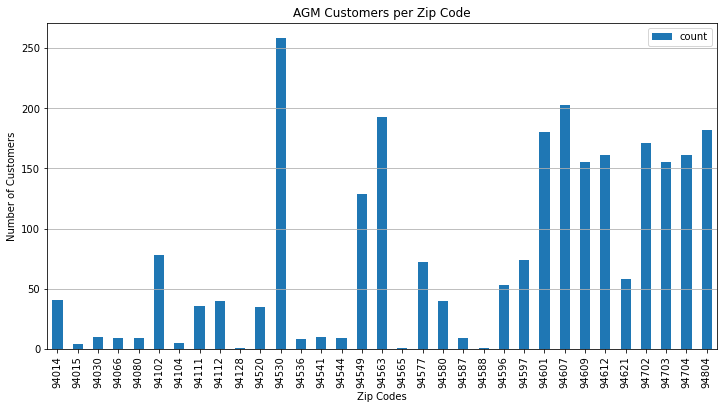

In [21]:
# ***********************************************************************************************************************
# 3. Prepare barplot of customer counts per zip code
# **********************************************************************************************************************

df_customers.set_index(df_customers['zip'],inplace=True)
df_customers.plot(kind='bar',figsize=(12,6),title='AGM Customers per Zip Code').grid(axis='y')
plt.xlabel('Zip Codes')
plt.ylabel('Number of Customers')
plt.xticks(rotation=90)
plt.show()

In [22]:
# **********************************************************************************************************************
# 4a. Create neo4j graph of nodes for zip codes along with graph of stations 
#   -- connect zip code nodes to station nodes with links indicating distance so distance from zip to station within 
#      same zip should be 0
#   
# **********************************************************************************************************************
#my_neo4j_wipe_out_database()
neo4j_create_station()

In [23]:
# **********************************************************************************************************************
# 4b. Add zip code to each station node based on station name 
# **********************************************************************************************************************
for i,z in enumerate(df_customers['zip']):
    #neo4j_create_node(z,"Count")
    #neo4j_create_relationship_one_way(z, z, str(df_customers['count'][i]))
   
    node_name = get_station_name_by_zip(z)
    pop_value = str(df_customers['count'][i])
    
    #print(pop_value)
    neo4j_add_pop_attribute(node_name, pop_value)


In [24]:
def neo4j_create_relationship_by_line_color(from_node, to_node, color, weight):
    "create a relationship between two stations with a weight:travel time"
    
    if color == 'blue':
        query = """
    
        MATCH (from:Station), 
          (to:Station)
        WHERE from.name = $from_node and to.name = $to_node
        CREATE (to)-[:BLUE {weight: $weight}]->(from)-[:BLUE {weight: $weight}]->(to)
    
        """
    elif color == 'gray':
        query = """
    
        MATCH (from:Station), 
          (to:Station)
        WHERE from.name = $from_node and to.name = $to_node
        CREATE (to)-[:GRAY {weight: $weight}]->(from)-[:GRAY {weight: $weight}]->(to)
    
        """
    elif color == 'green':
        query = """
    
        MATCH (from:Station), 
          (to:Station)
        WHERE from.name = $from_node and to.name = $to_node
        CREATE (to)-[:GREEN {weight: $weight}]->(from)-[:GREEN {weight: $weight}]->(to)
    
        """
    
    elif color == 'orange':
        query = """
    
        MATCH (from:Station), 
          (to:Station)
        WHERE from.name = $from_node and to.name = $to_node
        CREATE (to)-[:ORANGE {weight: $weight}]->(from)-[:ORANGE {weight: $weight}]->(to)
    
        """
    
    elif color == 'red':
        query = """
    
        MATCH (from:Station), 
          (to:Station)
        WHERE from.name = $from_node and to.name = $to_node
        CREATE (to)-[:RED {weight: $weight}]->(from)-[:RED {weight: $weight}]->(to)
    
        """
    
    elif color == 'yellow':
        query = """
    
        MATCH (from:Station), 
          (to:Station)
        WHERE from.name = $from_node and to.name = $to_node
        CREATE (to)-[:YELLOW {weight: $weight}]->(from)-[:YELLOW {weight: $weight}]->(to)
    
        """
    
    else:
        return
    
    session.run(query, from_node=from_node, to_node=to_node, weight=weight)

In [25]:
def neo4j_create_relationship(from_node, to_node, color, weight):
    "create a relationship between two stations with a weight:travel time"
    
    query = """
    
    MATCH (from:Station), 
        (to:Station)
    WHERE from.name = $from_node and to.name = $to_node
    CREATE (to)-[:TRACK {travel_time: $weight, line: $color}]->(from)-[:TRACK {travel_time: $weight, line: $color}]->(to)
    
    """

    session.run(query, from_node=from_node, to_node=to_node, weight=weight, color=color)

In [ ]:
# *****************************************
# UNIT TEST
# *****************************************
neo4j_create_relationship_by_line_color("Ashby", "MacArthur", "red", 80)

In [ ]:
# *****************************************
# UNIT TEST
# *****************************************
neo4j_create_relationship("Ashby", "MacArthur", 80)

In [26]:
# **********************************************************************************************************************
# 4c. Link stations, travel time and line color attribute to links
# **********************************************************************************************************************
line_colors = ['blue','gray','green','orange','red','yellow']

connection.rollback()

rollback_before_flag = True
rollback_after_flag = True

for lc in line_colors:
    query = """ 
    select sequence, station
    from lines
    where line = '%s'
    """.replace("%s",lc)
    
    df_line = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
    df_line
    cnt = len(df_line['station'])
    #print(lc)
    #print("COUNT: " + str(cnt))
    if cnt > 1:
        for i in range (cnt-1):
            #print(df_line['station'][i])
            #print(df_line['station'][i+1])
            stn1 = df_line['station'][i]
            stn2 = df_line['station'][i+1]
            
            #print(str(stn1) + "," + str(stn2))
            
            tt = neo4j_find_travel_time(stn1, stn2)
            
            #print(tt)
            #neo4j_create_relationship(stn1,stn2,lc,int(tt))
            neo4j_create_relationship(stn1,stn2,lc,int(tt))
    else:
        continue
        

Dublin,West Dublin
180
West Dublin,Castro Valley
600
Castro Valley,Bay Fair
240
Bay Fair,San Leandro
240
San Leandro,Coliseum
240
Coliseum,Fruitvale
240
Fruitvale,Lake Merritt
300
Lake Merritt,West Oakland
360
West Oakland,Embarcadero
420
Embarcadero,Montgomery Street
60
Montgomery Street,Powell Street
120
Powell Street,Civic Center
60
Civic Center,16th Street Mission
180
16th Street Mission,24th Street Mission
120
24th Street Mission,Glen Park
180
Glen Park,Balboa Park
120
Balboa Park,Daly City
240
OAK,Coliseum
480
Berryessa,Milpitas
300
Milpitas,Warm Springs
540
Warm Springs,Fremont
360
Fremont,Union City
300
Union City,South Hayward
300
South Hayward,Hayward
240
Hayward,Bay Fair
240
Bay Fair,San Leandro
240
San Leandro,Coliseum
240
Coliseum,Fruitvale
240
Fruitvale,Lake Merritt
300
Lake Merritt,West Oakland
360
West Oakland,Embarcadero
420
Embarcadero,Montgomery Street
60
Montgomery Street,Powell Street
120
Powell Street,Civic Center
60
Civic Center,16th Street Mission
180
16th Stree

#### SEARCH ALGORITHMS

In [52]:
# ************************************************************************************************************
# Shortest Path algorithm dijkstra
# ************************************************************************************************************
def neo4j_shortest_path(from_station, to_station):
    "given a from station and to station, run and print the shortest path"
    
    query = "CALL gds.graph.drop('ds_graph', false)"
    session.run(query)

    query = "CALL gds.graph.project('ds_graph', 'Station', 'TRACK', {relationshipProperties: 'travel_time'})"
    session.run(query)

    query = """

    MATCH (source:Station {name: $source}), (target:Station {name: $target})
    CALL gds.shortestPath.dijkstra.stream(
        'ds_graph', 
        { sourceNode: source, 
          targetNode: target, 
          relationshipWeightProperty: 'travel_time'
        }
    )
    YIELD index, sourceNode, targetNode, totalCost, nodeIds, costs, path
    RETURN
        gds.util.asNode(sourceNode).name AS from,
        gds.util.asNode(targetNode).name AS to,
        totalCost,
        [nodeId IN nodeIds | gds.util.asNode(nodeId).name] AS nodes,
        costs
    ORDER BY index

    """

    result = session.run(query, source=from_station, target=to_station)
    
    for r in result:
        
        total_cost = int(r['totalCost'])
        
        print("\n--------------------------------")
        print("   Total Cost: ", total_cost)
        print("   Minutes: ", round(total_cost / 60.0,1))
        print("--------------------------------")
        
        nodes = r['nodes']
        costs = r['costs']
        
        i = 0
        previous = 0
        
        for n in nodes:
            
            print(n + ", " + str(int(costs[i]) - previous)  + ", " + str(int(costs[i])))
            
            previous = int(costs[i])
            i += 1      

In [53]:
neo4j_shortest_path("Antioch","Richmond")


--------------------------------
   Total Cost:  4380
   Minutes:  73.0
--------------------------------
Antioch, 0, 0
Pittsburg Center, 420, 420
Pittsburg, 600, 1020
North Concord, 360, 1380
Concord, 180, 1560
Pleasant Hill, 360, 1920
Walnut Creek, 120, 2040
Lafayette, 300, 2340
Orinda, 300, 2640
Rockridge, 300, 2940
MacArthur, 240, 3180
Ashby, 240, 3420
Downtown Berkeley, 180, 3600
North Berkeley, 120, 3720
El Cerrito Plaza, 180, 3900
El Cerrito del Norte, 180, 4080
Richmond, 300, 4380


In [54]:
# ************************************************************************************************************
# Shortest Path algorithm all-pairs
# ************************************************************************************************************
def neo4j_all_pairs_shortest_path(from_station, to_station):
    "given a from station and to station, run and print the shortest path"
    
    query = "CALL gds.graph.drop('ds_graph', false)"
    session.run(query)

    query = "CALL gds.graph.project('ds_graph', 'Station', 'TRACK', {relationshipProperties: 'travel_time'})"
    session.run(query)
    
    query = """

    MATCH (n:Station {name: $source})
    CALL gds.allShortestPaths.delta.stream('ds_graph', 
                                       {sourceNode: n,
                                        relationshipWeightProperty: 'travel_time',
                                        delta: 3.0
                                       }
                                      )
                                        
    YIELD index, sourceNode, targetNode, totalCost, nodeIds, costs, path
    RETURN
        index,
        gds.util.asNode(sourceNode).name AS sourceNodeName,
        gds.util.asNode(targetNode).name AS targetNodeName,
        totalCost,
        [nodeId IN nodeIds | gds.util.asNode(nodeId).name] AS nodeNames,
        costs,
        nodes(path) as path
    ORDER BY index

    """

    res = my_neo4j_run_query_pandas(query, source=from_station, target=to_station)
    print(res)
    #result = session.run(query, source=from_station, target=to_station)

In [55]:
neo4j_all_pairs_shortest_path("MacArthur","El Cerrito Plaza")

    index sourceNodeName        targetNodeName  totalCost  \
0       0      MacArthur           12th Street      300.0   
1       1      MacArthur   16th Street Mission     1440.0   
2       2      MacArthur           19th Street      180.0   
3       3      MacArthur   24th Street Mission     1560.0   
4       4      MacArthur               Antioch     3180.0   
5       5      MacArthur                 Ashby      240.0   
6       6      MacArthur           Balboa Park     1860.0   
7       7      MacArthur              Bay Fair     1500.0   
8       8      MacArthur             Berryessa     3780.0   
9       9      MacArthur         Castro Valley     1740.0   
10     10      MacArthur          Civic Center     1260.0   
11     11      MacArthur              Coliseum     1020.0   
12     12      MacArthur                 Colma     2340.0   
13     13      MacArthur               Concord     1620.0   
14     14      MacArthur             Daly City     2100.0   
15     15      MacArthur

#### CENTRALITY ALGORITHMS

In [56]:
def neo4j_page_rank():
    "given a from station and to station, run and print the shortest path"
    
    query = "CALL gds.graph.drop('ds_graph', false)"
    session.run(query)

    query = "CALL gds.graph.project('ds_graph', 'Station', 'TRACK', {relationshipProperties: 'travel_time'})"
    session.run(query)
    
    query = """

    CALL gds.pageRank.stream('ds_graph')
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).name AS name, score, gds.util.asNode(nodeId).pop AS customers
    ORDER BY score DESC, name ASC, customers DESC

    """
    
    #result = session.run(query)
    
    #print("Station Name : Station Rank Score")
    #for r in result:
    #    name = r['name']
    #    score = float(r['score'])
    #    print(name," : ",score)
    
    res = my_neo4j_run_query_pandas(query)
    print(res)

In [57]:
neo4j_page_rank()

                    name     score customers
0               Coliseum  1.387533        58
1               Bay Fair  1.375688        40
2              MacArthur  1.291159       155
3            San Leandro  1.230845        72
4            Balboa Park  1.163400        40
5           West Oakland  1.158007         0
6              San Bruno  1.142995         9
7            19th Street  1.117343       161
8       Pittsburg Center  1.115549         1
9               Milpitas  1.115419         0
10  El Cerrito del Norte  1.110790       258
11             Glen Park  1.071030         0
12           Embarcadero  1.067680        36
13             Fruitvale  1.065852       180
14             Pittsburg  1.043628         0
15          Warm Springs  1.043566         0
16      El Cerrito Plaza  1.036565         0
17   24th Street Mission  1.022083         0
18     Montgomery Street  1.019887         0
19               Fremont  1.003626         8
20           12th Street  1.003171       203
21        

In [59]:
def neo4j_between():
    "given a from station and to station, run and print the shortest path"
    
    query = "CALL gds.graph.drop('ds_graph', false)"
    session.run(query)

    query = "CALL gds.graph.project('ds_graph', 'Station', 'TRACK', {relationshipProperties: 'travel_time'})"   
    session.run(query)
    
    query = """

    CALL gds.betweenness.stream('ds_graph')
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).name AS name, score, gds.util.asNode(nodeId).pop AS customers
    ORDER BY score DESC, name ASC, customers DESC

    """
    
    #result = session.run(query)
    
    #print("Station Name : Betweenness Centrality")
    #for r in result:
    #    name = r['name']
    #    score = float(r['score'])
    #    print(name," : ",score)
    
    res = my_neo4j_run_query_pandas(query)
    print(res)

In [60]:
neo4j_between()

                    name   score customers
0              MacArthur  1176.0       155
1            12th Street  1116.0       203
2            19th Street  1088.0       161
3           Lake Merritt  1020.0         0
4              Fruitvale   980.0       180
5           West Oakland   980.0         0
6               Coliseum   960.0        58
7            Embarcadero   936.0        36
8      Montgomery Street   888.0         0
9          Powell Street   836.0         5
10           San Leandro   836.0        72
11              Bay Fair   822.0        40
12          Civic Center   780.0        78
13   16th Street Mission   720.0         0
14             Rockridge   720.0         0
15   24th Street Mission   656.0         0
16                Orinda   656.0       193
17             Glen Park   588.0         0
18             Lafayette   588.0       129
19           Balboa Park   516.0        40
20               Hayward   516.0         0
21          Walnut Creek   516.0        53
22         

In [61]:
def neo4j_closeness():
    "given a from station and to station, run and print the shortest path"
    
    query = "CALL gds.graph.drop('ds_graph', false)"
    session.run(query)

    query = "CALL gds.graph.project('ds_graph', 'Station', 'TRACK', {relationshipProperties: 'travel_time'})"   
    session.run(query)
    
    query = """

    CALL gds.beta.closeness.stream('ds_graph')
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).name AS name, score, gds.util.asNode(nodeId).pop AS customers
    ORDER BY score DESC, name ASC, customers DESC

    """
    
    #result = session.run(query)
    
    #print("Station Name : Closeness")
    #for r in result:
    #    name = r['name']
    #    score = float(r['score'])
    #    print(name," : ",score)
        
    res = my_neo4j_run_query_pandas(query)
    print(res)

In [62]:
neo4j_closeness()

                    name     score customers
0            12th Street  0.147147       203
1           Lake Merritt  0.145833         0
2           West Oakland  0.145401         0
3            19th Street  0.141210       161
4              Fruitvale  0.137640       180
5            Embarcadero  0.136490        36
6              MacArthur  0.134986       155
7               Coliseum  0.129630        58
8      Montgomery Street  0.127937         0
9              Rockridge  0.124682         0
10                 Ashby  0.122195       155
11           San Leandro  0.121287        72
12         Powell Street  0.119804         5
13                Orinda  0.115294       193
14                   OAK  0.115023         0
15              Bay Fair  0.113426        40
16          Civic Center  0.112128        78
17     Downtown Berkeley  0.111111       161
18             Lafayette  0.106754       129
19   16th Street Mission  0.104925         0
20               Hayward  0.104701         0
21        

#### Business Scenario 2

Given traffic congestion "real time" data, compute shortest BART transportation path to avoid congestion

* Import traffic data either from Redis or canned file
* Update weights on links to make congested paths more costly
* Run shortest path (or other) algorithms
* Deploy mobile robots to dangling nodes and deliver product to nearest open pickup location
* Compute next nearest location also accounting for removed Links due to planned track maintenance

 (Traffic congestion data -- extreme, high, medium, low as input feed. Update transit times by
 factors of 100, 10, 2, 1. Run route planning algorithm based on congestion.)


In [ ]:
# **********************************************************************************************************************
# Business Scenario 2
#
# Given traffic congestion "real time" data, compute shortest 
# BART transportation path to avoid congestion
#
# Import traffic data either from Redis or canned file
# Update weights on links to make congested paths more costly
# Run shortest path (or other) algorithms
#   
# (Traffic congestion data -- extreme, high, medium, low as input feed. Update transit times by
# factors of 100, 10, 2, 1. Run route planning algorithm based on congestion.)
# *********************************************************************************************************************

In [ ]:
# ADD SCENARIO 2